In [1]:
import pandas as pd
from datetime import datetime
from datetime import timedelta
from functools import partial
import matplotlib.pyplot as plt
import numpy as np

In [2]:
daily_sales_data = pd.read_csv('train.csv')
store_data = pd.read_csv('store.csv')

# This makes it easier to do timeseries analysis later on
convert_dates = partial(datetime.strptime, '%Y-%m-%d')
daily_sales_data['Date'] = daily_sales_data['Date'].apply(lambda x: datetime.strptime(x, '%Y-%m-%d'))

/usr/lib/python3.6/site-packages/IPython/core/interactiveshell.py:2717: DtypeWarning: Columns (7) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


Store Counts:

**85%** of Rossman's Stores are **type A/C** with **1.5%** being **type B.**

**99%** of stores are of **assortment A/C**.

100% of assortment B stores are type B.

In [3]:
print(store_data['StoreType'].value_counts())
print('-' * 10)
print(store_data['Assortment'].value_counts())
print('-' * 10)
combinations = sorted([(a, b) for a in store_data['StoreType'].unique() for b in store_data['Assortment'].unique()])
counts = { (a, b):len( store_data[ store_data.StoreType == a ][ store_data.Assortment == b] ) for (a,b) in combinations}
for j in sorted(counts.keys()):
    print('{}/{}: {}'.format(j[0].upper(), j[1].upper(), counts[j]))
print('Name: Store Type / Assortment')

a    602
d    348
c    148
b     17
Name: StoreType, dtype: int64
----------
a    593
c    513
b      9
Name: Assortment, dtype: int64
----------
A/A: 381
A/B: 0
A/C: 221
B/A: 7
B/B: 9
B/C: 1
C/A: 77
C/B: 0
C/C: 71
D/A: 128
D/B: 0
D/C: 220
Name: Store Type / Assortment


/usr/lib/python3.6/site-packages/ipykernel/__main__.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.


Average sales for **type B** stores are **$4000+ higher than A/C/D**

In [32]:
def compile_stores(store_numbers):
    """Group the sales daily_sales_data of a list of stores"""
    # Empty daily_sales_dataframe
    filtered_stores = daily_sales_data[daily_sales_data.Sales == -8384]
    for j in store_numbers:
        matches = daily_sales_data[daily_sales_data.Store == j]
        filtered_stores = filtered_stores.append(matches)
    return filtered_stores

def group_by_store_type(store_type, exclude_no_sales=False, attribute='StoreType'):
    store_numbers = list(store_data[store_data[attribute] == store_type]['Store'])
    if exclude_no_sales:
        store_numbers = store_numbers[store_numbers.Sales > 0]
    matches = compile_stores(store_numbers)
    return matches

def plot_sales_averages(type_groups, labels=('A', 'B', 'C', 'D'), sale_color='r', customer_color='y', legend=True):
    """Plot the daily_sales_data"""
    indices = np.arange(len(type_groups))
    sales_means = [x.describe()['Sales']['mean'] for x in type_groups]
    customer_means = [x.describe()['Customers']['mean'] for x in type_groups]
    WIDTH = 0.35
    fig, ax = plt.subplots()
    sales_bars = ax.bar(indices, sales_means, WIDTH, color=sale_color)
    customer_bars = ax.bar(indices + WIDTH, customer_means, WIDTH, color=customer_color)
    plt.xticks(indices, labels)
    if legend:
        plt.legend((sales_bars[0], customer_bars[0]), ('Average Sales', 'Average Shoppers'))
    plt.figure()
    sales_daily_sales_data = [np.array(x['Sales']) for x in type_groups]
    plt.boxplot(sales_daily_sales_data, 0 , 'rs')
    plt.xticks(1 + indices,(labels))
    plt.show()
    

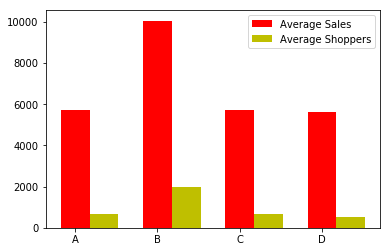

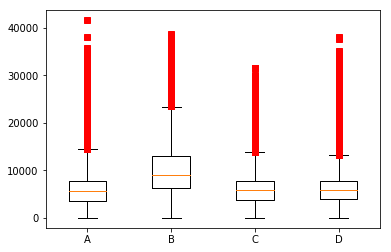

In [27]:
type_a = group_by_store_type('a')
type_b = group_by_store_type('b')
type_c = group_by_store_type('c')
type_d = group_by_store_type('d')

plot_sales_averages((type_a, type_b, type_c, type_d))

**Type B stores are open more** than store types A/C/D

At this point it is clear that type B stores are the rare cream of the crop of the Rossman stores.

/usr/lib/python3.6/site-packages/ipykernel/__main__.py:8: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/usr/lib/python3.6/site-packages/ipykernel/__main__.py:9: UserWarning: Boolean Series key will be reindexed to match DataFrame index.


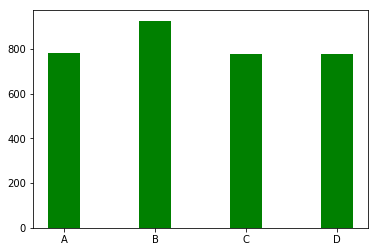

In [110]:
def open_ratio(store_type_daily_sales_data):
    store_type_dates = store_type_daily_sales_data['Date'].unique()
    ratio = 0
    open_count = 0
    total_stores = len(store_type_daily_sales_data)
    for day in store_type_dates:
        open_count = len(store_type_daily_sales_data[store_type_daily_sales_data.Date == day][store_type_daily_sales_data.Open == 1])
        closed_count = len(store_type_daily_sales_data[store_type_daily_sales_data.Date == day][store_type_daily_sales_data.Open == 0])
        ratio += (open_count / (open_count + closed_count))
    return ratio
indices = np.arange(4)
WIDTH = 0.35
open_index = [open_ratio(x) for x in (type_a, type_b, type_c, type_d)]
plt.bar(indices, open_index, WIDTH, color='g')
plt.xticks(indices, ('A', 'B', 'C', 'D'))
plt.show()

Stores closer to competitors, regardless of type, do better than farther away stores.

Speculation suggests this may be due to being located in a large shopping center

In [12]:
def retrieve_quantiles(store_type, attribute):
    return store_data[store_data.StoreType == store_type][attribute].quantile([0.25, 0.50, 0.75])

def retrieve_matches(quantiles):
    q1 = store_data[store_data.CompetitionDistance <= quantiles[0.25]]
    q2 = store_data[store_data.CompetitionDistance > quantiles[0.25]]
    q2 = q2[q2.CompetitionDistance <= quantiles[0.50]]
    q3 = store_data[store_data.CompetitionDistance > quantiles[0.50]]
    q3 = q3[q3.CompetitionDistance <= quantiles[0.75]]
    q4 = store_data[store_data.CompetitionDistance > quantiles[0.75]]
    
    return q1['Store'], q2['Store'], q3['Store'], q4['Store']

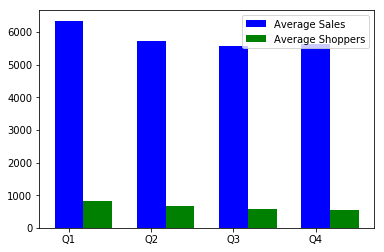

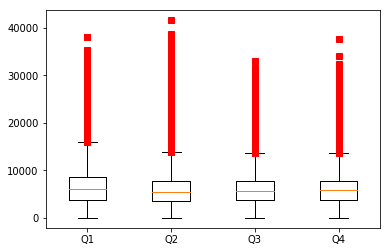

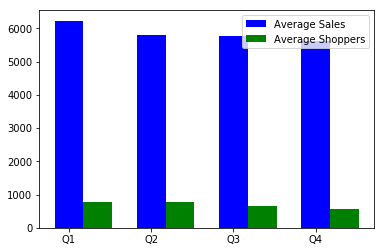

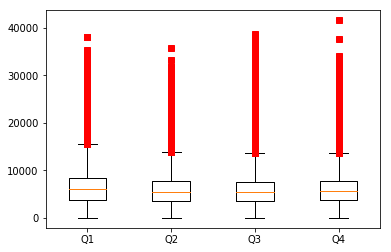

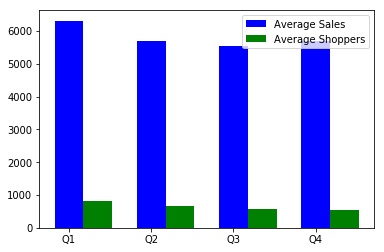

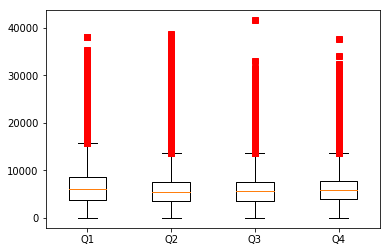

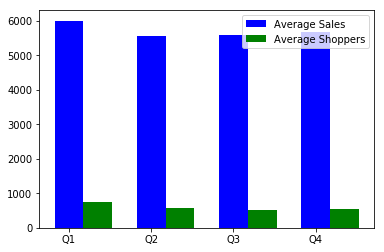

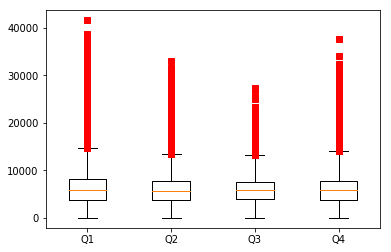

In [13]:
for store_type in ('a', 'b', 'c', 'd'):
    quantiles = retrieve_quantiles(store_type, 'CompetitionDistance')
    q1, q2, q3, q4 = retrieve_matches(quantiles)

    q1 = compile_stores(q1)
    q2 = compile_stores(q2)
    q3 = compile_stores(q3)
    q4 = compile_stores(q4)

    plot_sales_averages((q1, q2, q3, q4), ('Q1', 'Q2', 'Q3', 'Q4'), 'b', 'g')

Average Sales for a promotional day are $4000 higher than non-promotional days

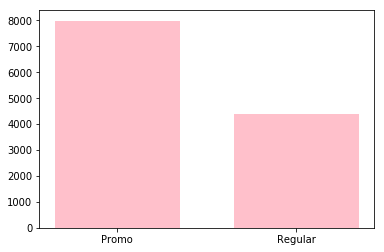

In [11]:
promo_days = daily_sales_data[daily_sales_data.Promo == 1]
promo_avg =  promo_days.describe()['Sales']['mean']
no_promo_days = daily_sales_data[daily_sales_data.Promo == 0]
reg_day_avg = no_promo_days.describe()['Sales']['mean']
plt.bar((0, 0.5), (promo_avg, reg_day_avg), width=0.35, color='pink')
plt.xticks((0, 0.5), ('Promo', 'Regular'))
plt.show()

The day after a sale doesn't experience a drop in sales

In [15]:
promo_dates = promo_days['Date'].unique()
promo_dates = [pd.to_datetime(d) for d in promo_dates]
day_after_promo = [d + timedelta(1) for d in promo_dates]
final_promo_dates = []

for d in promo_dates:
    d = pd.to_datetime(d)
    if d + timedelta(1) not in promo_dates:
        final_promo_dates.append(d)
day_after_promo = [d + timedelta(1) for d in final_promo_dates]
filtered_stores = daily_sales_data[daily_sales_data.Sales == -8843]

for date in day_after_promo:
    filtered_stores = filtered_stores.append(daily_sales_data[daily_sales_data.Date == date])

# Empty daily_sales_dataframe
filtered_stores = daily_sales_data[daily_sales_data.Sales == -8843]

for date in day_after_promo:
    filtered_stores = filtered_stores.append(daily_sales_data[daily_sales_data.Date == date])

day_after_avg = filtered_stores.describe()['Sales']['mean']

filtered_stores2 = daily_sales_data[daily_sales_data.Sales == -8843]
for date in day_after_promo:
    x = daily_sales_data[daily_sales_data.Date != date][daily_sales_data.Promo == 0]
    filtered_stores2 = filtered_stores.append(x)

reg_day_avg2 = filtered_stores2.describe()['Sales']['mean']

print(day_after_avg, reg_day_avg2)

/usr/lib/python3.6/site-packages/ipykernel/__main__.py:27: UserWarning: Boolean Series key will be reindexed to match DataFrame index.


5935.77350422 4570.52057904


There is a **strong correlation** between **day of week and sales**

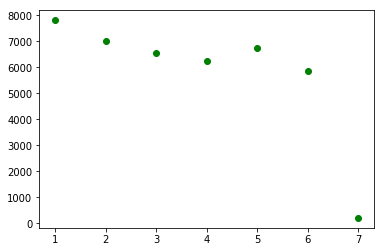

,DayOfWeek,Mean
DayOfWeek,1.000000,-0.761059
Mean,-0.761059,1.000000


In [16]:
individual_days = {day: daily_sales_data[daily_sales_data['DayOfWeek'] == day]for day in range(1,8)}
day_of_week_avgs = [individual_days[i].describe()['Sales']['mean'] for i in individual_days.keys()]
plt.scatter(range(1, 8), day_of_week_avgs, color='green')
plt.show()

daily_avgs = pd.daily_sales_dataFrame()
daily_avgs['DayOfWeek'] = range(1, 8)
daily_avgs['Mean'] = day_of_week_avgs

daily_avgs.corr()

Assorment C stores outperform assorments A/B

In [25]:
def merge_assorment_type(store_type):
    assorment_a = group_by_store_type('a', attribute='Assortment')
    assorment_b = group_by_store_type('b', attribute='Assortment')
    assorment_c = group_by_store_type('c', attribute='Assortment')
    
    m1 = pd.merge(assorment_a, store_type)
    m2 = pd.merge(assorment_b, store_type)
    m3 = pd.merge(assorment_c, store_type)
    
    return m1, m2, m3

In [28]:
type_a_assortment_a, type_a_assortment_b, type_a_assortment_c = merge_assorment_type(type_a)
type_b_assortment_a, type_b_assortment_b, type_b_assortment_c = merge_assorment_type(type_b)
type_c_assortment_a, type_c_assortment_b, type_c_assortment_c = merge_assorment_type(type_c)
type_d_assortment_a, type_d_assortment_b, type_d_assortment_c = merge_assorment_type(type_d)

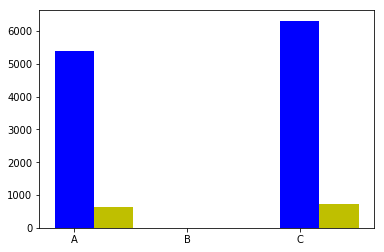

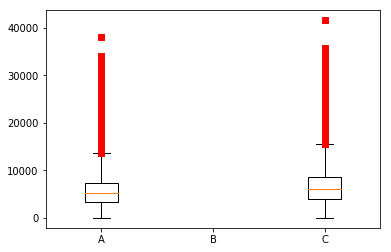

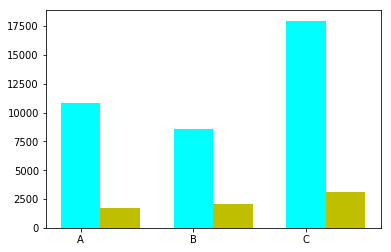

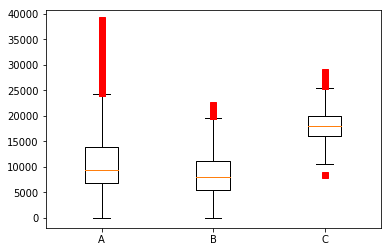

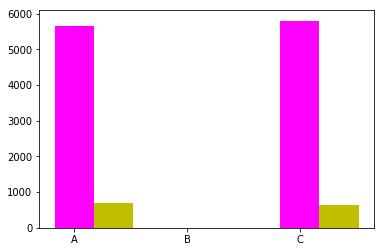

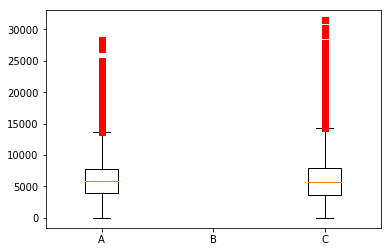

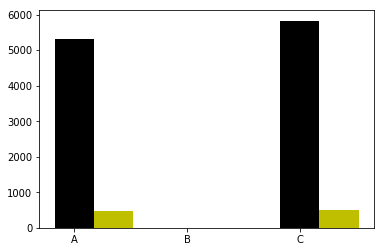

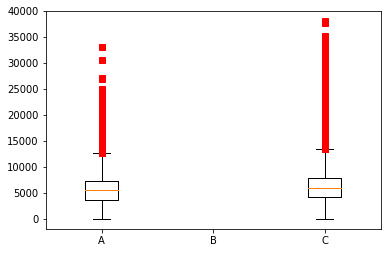

In [37]:
plot_sales_averages((type_a_assortment_a, type_a_assortment_b, type_a_assortment_c), sale_color='blue', legend=False)
plot_sales_averages((type_b_assortment_a, type_b_assortment_b, type_b_assortment_c), sale_color='cyan', legend=False)
plot_sales_averages((type_c_assortment_a, type_c_assortment_b, type_c_assortment_c), sale_color='magenta', legend=False)
plot_sales_averages((type_d_assortment_a, type_d_assortment_b, type_d_assortment_c), sale_color='black', legend=False)